# Astrometric analysis with ePSF

## Importing some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.visualization import simple_norm

## Loading image

Text(0, 0.5, 'Y (px)')

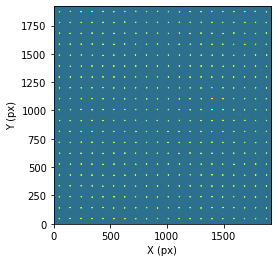

In [2]:
hdu = pf.open("image00.fits")[0]
data = hdu.data.astype(np.float32)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')

## Finding peaks with photutils.detection.find_peaks

In [3]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=500.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   527     46       1759
   624     46       1875
   720     46       1782
   816     46       1763
  1199     46       1769
  1295     46       1857
  1390     46       1819
  1486     46       1833
    46     47       1811
   335     47       1803
   ...    ...        ...
  1583   1870       1854
  1680   1870       1809
   334   1871       1798
   623   1871       1784
  1486   1871       1735
   144   1872       1766
   431   1872       1801
  1389   1872       1881
  1772   1872       1774
   719   1873       1766
   912   1873       1778
Length = 402 rows


## Removing data in edge regions

In [4]:
mask_size = 25 
hsize = (mask_size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))
print(peaks_tbl[mask])

x_peak y_peak peak_value
------ ------ ----------
   527     46       1759
   624     46       1875
   720     46       1782
   816     46       1763
  1199     46       1769
  1295     46       1857
  1390     46       1819
  1486     46       1833
    46     47       1811
   335     47       1803
   ...    ...        ...
  1583   1870       1854
  1680   1870       1809
   334   1871       1798
   623   1871       1784
  1486   1871       1735
   144   1872       1766
   431   1872       1801
  1389   1872       1881
  1772   1872       1774
   719   1873       1766
   912   1873       1778
Length = 402 rows


In [5]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask] 
stars_tbl['y'] = y[mask]

## Subtracting background

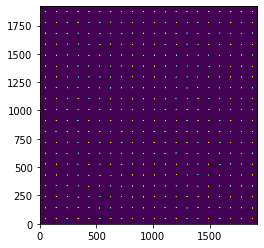

In [6]:
from astropy.stats import sigma_clipped_stats
from photutils.background import MMMBackground
import copy
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

## Extracting stellar images

In [7]:
from astropy.nddata import NDData
nddata = NDData(data=data)  
print(nddata.data.shape)

(1920, 1920)


In [8]:
from photutils.psf import extract_stars
size = 9
stars = extract_stars(nddata, stars_tbl, size=size)

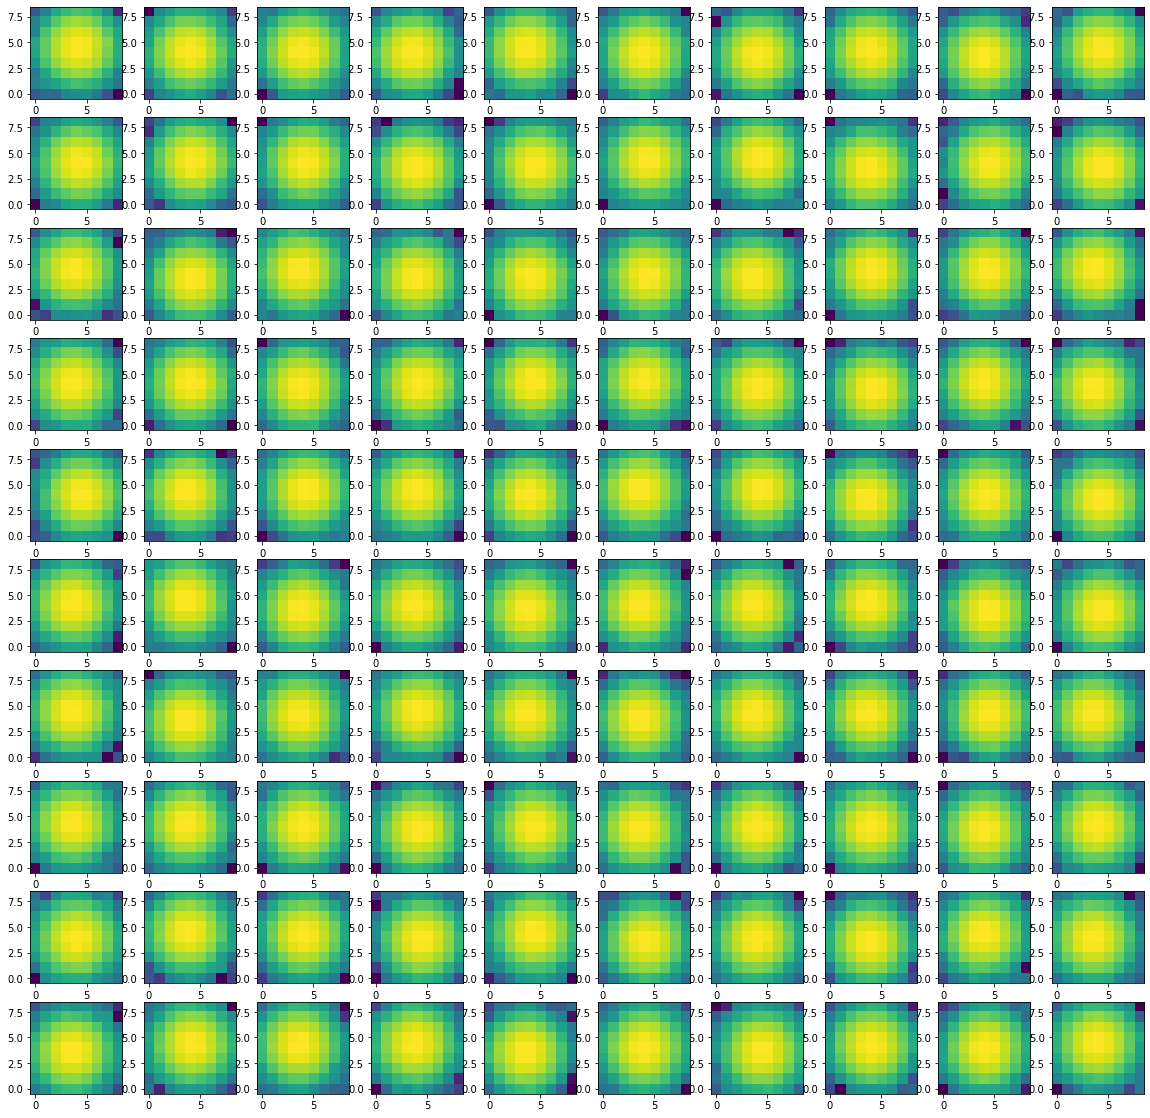

In [9]:
nrows = 10
ncols = 10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

## Making ePSF data

In [10]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

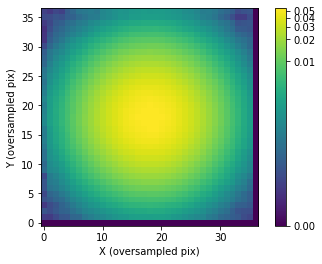

In [11]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()

## Checking radial profile

Text(0, 0.5, 'Signal (a.u.)')

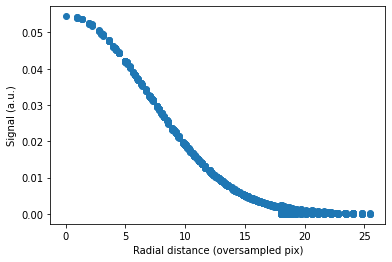

In [12]:
shape = np.shape(epsf.data)
iy, ix = np.indices(shape)
dy = iy - (shape[0]-1)*0.5
dx = ix - (shape[1]-1)*0.5
d = np.sqrt(dx**2.+dy**2.)
plt.scatter(d.flatten(), epsf.data.flatten())
plt.xlabel('Radial distance (oversampled pix)')
plt.ylabel('Signal (a.u.)')

## Gaussian fitting of the core profile

Text(0, 0.5, 'Signal (a.u.)')

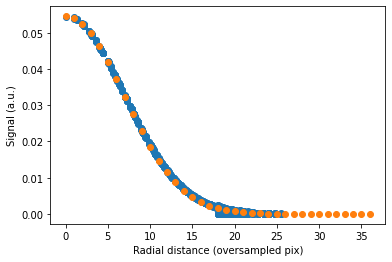

In [13]:
import warnings
from astropy.modeling import models, fitting

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=.1, mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
pos = np.where(d.flatten()<5.)
g = fit_g(g_init, d.flatten()[pos], epsf.data.flatten()[pos])

plt.scatter(d.flatten(), epsf.data.flatten())
x=np.arange(0,shape[0])
plt.scatter(x, g(x))
plt.xlabel('Radial distance (oversampled pix)')
plt.ylabel('Signal (a.u.)')

In [14]:
g

<Gaussian1D(amplitude=0.05458843, mean=0.14094613, stddev=6.7080811)>

stddev = 6.7 (oversampled) -> 1.7 (original sampling).

## Comparing stellar positions with input catalog

### Loading the input catalog

In [15]:
original = np.loadtxt("../../01_params/spcsv_20_1920_10_20_12.0.csv",skiprows=1,delimiter=",")

In [16]:
xc_array = []
for o in original:
    diff = fitted_stars.center_flat-np.array([o[2],o[3]])
    p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
    if np.size(p) == 1:
        xc_array.append([o[2], o[3],
                         fitted_stars.center_flat[p[0][0]][0],
                         fitted_stars.center_flat[p[0][0]][1]])
xc_array = np.array(xc_array)

### Plotting the positions

(0.0, 1920.0)

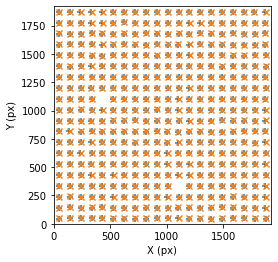

In [17]:
plt.axes().set_aspect('equal')
plt.scatter(xc_array[:,2], xc_array[:,3], marker='+', label='Fitted')
plt.scatter(xc_array[:,0], xc_array[:,1], marker='x', label='Input')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1920])
plt.ylim([0, 1920])

### Plotting positional difference

Text(0, 0.5, '$\\Delta$y (px)')

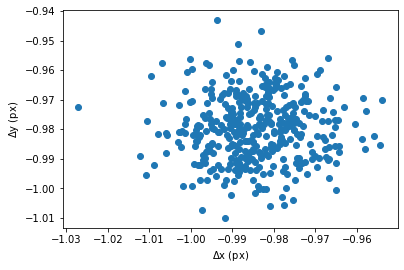

In [18]:
plt.scatter(xc_array[:,2]-xc_array[:,0],
            xc_array[:,3]-xc_array[:,1])
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')

### Checking the positional differences in vector plot

In [21]:
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]

dx = dx - np.mean(dx)
dy = dy - np.mean(dy)

Here, we subtracted the average values of the positional differences to omit the global offset caused by the ACE effect.
The ACE is offset to make its average value to be zero, and the first value is not zero usually.
The average ACE is expected to be non-zero value, and it also offsets the stellar positions on the detector globally.

(0.0, 1920.0)

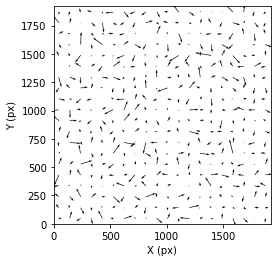

In [27]:
plt.axes().set_aspect('equal')
plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
           angles='xy', scale_units='xy', scale=0.0003)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1920])
plt.ylim([0, 1920])

In [28]:
print("STDDEV DX: {} px".format(np.std(dx)))
print("STDDEV DY: {} px".format(np.std(dy)))

STDDEV DX: 0.010818267940724009 px
STDDEV DY: 0.010955211098401337 px
